In [1]:
import numpy as np
import tensorflow as tf

In [2]:
class DatasetGenerator:
    """
    TensorFlow Dataset from Python/NumPy Iterator
    
    Loads the 2D slices NumPy files that were created via convert_raw_to_numpy.py
    """
    
    
    def __init__(self, dirName, batch_size=8, crop_dim=[240,240], augment=False, seed=816):
        
        self.dirName = dirName
        self.batch_size = batch_size
        self.crop_dim = crop_dim
        self.augment = augment
        self.seed = seed
        
    
    def crop_input(self, img, msk):
        """
        Randomly crop the image and mask
        """

        slices = []

        # Do we randomize?
        is_random = self.augment and np.random.rand() > 0.5

        for idx in range(2):  # Go through each dimension

            cropLen = self.crop_dim[idx]
            imgLen = img.shape[idx]

            start = (imgLen-cropLen)//2

            ratio_crop = 0.20  # Crop up this this % of pixels for offset
            # Number of pixels to offset crop in this dimension
            offset = int(np.floor(start*ratio_crop))

            if offset > 0:
                if is_random:
                    start += np.random.choice(range(-offset, offset))
                    if ((start + cropLen) > imgLen):  # Don't fall off the image
                        start = (imgLen-cropLen)//2
            else:
                start = 0

            slices.append(slice(start, start+cropLen))

        return img[tuple(slices)], msk[tuple(slices)]

    def combine_mask(self, msk):
        """
        Combine the masks into one mask
        """
        msk[msk > 0] = 1.0

        return msk
    
    def augment_data(self, img, msk):
        """
        Data augmentation
        Flip image and mask. Rotate image and mask.
        """
        
        if np.random.rand() > 0.5:
            ax = np.random.choice([0,1])
            img = np.flip(img, ax)
            msk = np.flip(msk, ax)

        if np.random.rand() > 0.5:
            rot = np.random.choice([1, 2, 3])  # 90, 180, or 270 degrees

            img = np.rot90(img, rot, axes=[0,1])  # Rotate axes 0 and 1
            msk = np.rot90(msk, rot, axes=[0,1])  # Rotate axes 0 and 1

        return img, msk
    
    def read_file(self, fileIdx):
        """
        Read from the NumPy file
        """

        with np.load(fileIdx.numpy()) as data:
            img = data["img"]
            msk = data["msk"]

        msk = self.combine_mask(msk)

        img, msk = self.crop_input(img, msk)
        if self.augment:
            img, msk = self.augment_data(img, msk)

        return img, msk
    
    def get_dataset(self):
        """
        Return a dataset
        """
        file_list = tf.io.gfile.glob(self.dirName)
        ds = tf.data.Dataset.from_tensor_slices(file_list).shuffle(len(file_list),seed=self.seed)
        ds = ds.map(lambda x: tf.py_function(self.read_file,
                    [x], [tf.float32, tf.float32]),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

        return ds      
    
    def plot_dataset(self):
        """
        Plot some dataset samples
        """
        import matplotlib.pyplot as plt
        
        dt = self.get_dataset().take(1).as_numpy_iterator()
        plt.figure(figsize=(20,20))
        for img, msk in dt:
            for idx in range(img.shape[0]):
                plt.subplot(img.shape[0],2,1+2*idx)
                plt.imshow(img[idx,:,:,0], cmap="bone")
                plt.subplot(img.shape[0],2,2+2*idx)
                plt.imshow(msk[idx,:,:], cmap="bone")

In [3]:
ds_train = DatasetGenerator(dirName="../../data/decathlon/train/*.npz", 
                       batch_size=4, 
                       augment=True, 
                       seed=816).get_dataset()
ds_validation = DatasetGenerator(dirName="../../data/decathlon/validation/*.npz", 
                       batch_size=4, 
                       augment=True, 
                       seed=816).get_dataset()

ds_test = DatasetGenerator(dirName="../../data/decathlon/testing/*.npz", 
                       batch_size=4, 
                       augment=True, 
                       seed=816).get_dataset()

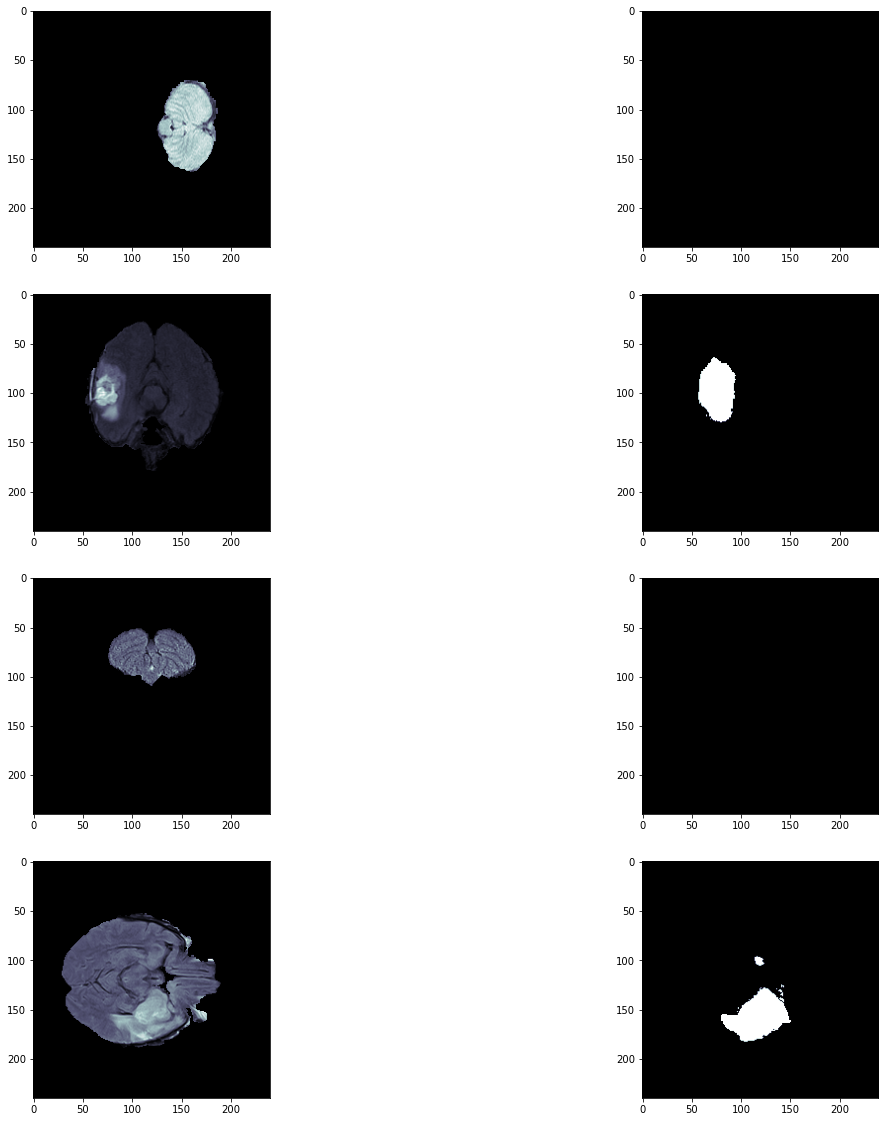

In [4]:
ds_train = DatasetGenerator(dirName="../../data/decathlon/train/*.npz", 
                       batch_size=4, 
                       augment=True, 
                       seed=816).plot_dataset()

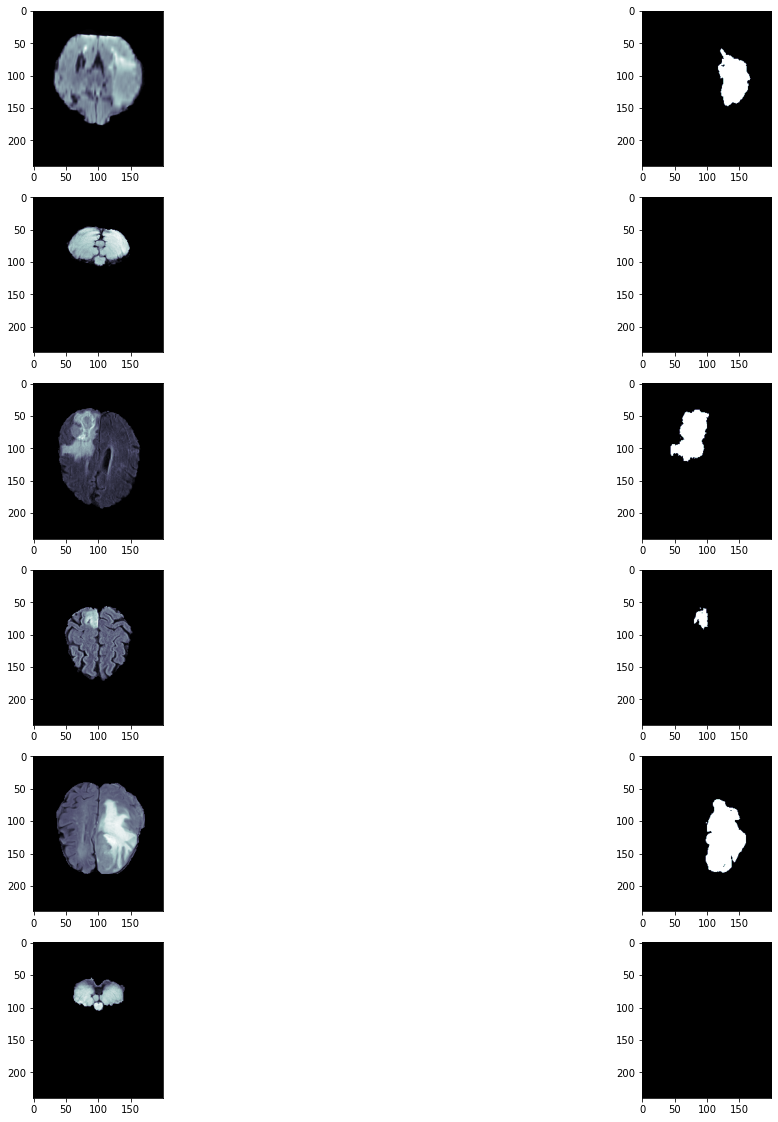

In [8]:
ds_train = DatasetGenerator(dirName="../../data/decathlon/testing/*.npz", 
                       batch_size=6, 
                       crop_dim = [240,200],
                       augment=False, 
                       seed=916).plot_dataset()